In [1]:
# Parameter inputs
# Parameters to set
URL_node_normalizer = 'https://nodenormalization-sri.renci.org/get_normalized_nodes'
trapi_submit_url = "http://robokop-automat.apps.renci.org/robokopkg/1.4/query"

def URL_name_resolution_search(search_string):
    return(f'https://name-resolution-sri.renci.org/lookup?string={search_string}&offset=0&limit=10')

# Initializing directory to write
from datetime import datetime
from pathlib import Path

now = datetime.now()
dt_string = now.strftime("%Y-%m-%d_%H%M%S")
write_dir = Path("output/compare",str(dt_string))
print(write_dir)
write_dir.mkdir(parents=True, exist_ok=True)

output\compare\2023-10-23_124906


The purpose of this notebook is to demonstrate how to make comparisons between different sets of results.  This is demonstrated by using results of a test query using TRAPI.  The first section, [TRAPI query results](#TRAPI-query-results), is to get a set of data to use for comparisons and place them in the same output directory shown in the cell immediately below.  Here, the pathways `Buprenorphine-OPRM1-Asterixis` and `Brixadi-OPRM1-Asterixis` are compared.

The compare_results() function is then demonstrated by taking the results from the query and showing a Venn diagram plot showing the number of edges in common and comparison plot showing missing edges.  For this notebook, if a different query is used or a different comparison is to be made, the files being read for comparison must be specified manually.

## TRAPI query results

Using the Name Resolver and test case from the `HelloRobokop` notebook series, a list of input IDs is generated from the search term `Buprenorphine`.

In [3]:
import requests
import json

import pprint
pp = pprint.PrettyPrinter(indent=5)

results = requests.post(URL_name_resolution_search('Buprenorphine'))
results_json = results.json()

input_node_id_list = []
for result in results_json:
    id = result['curie']
    if id not in input_node_id_list:
        input_node_id_list.append(id)

nn_query = {
  "curies": input_node_id_list,
  "conflate": True
}

results = requests.post(URL_node_normalizer,json=nn_query)

print(input_node_id_list)

['PUBCHEM.COMPOUND:644073', 'PUBCHEM.COMPOUND:165429853', 'UMLS:C0615670', 'UMLS:C0524040', 'PUBCHEM.COMPOUND:57383391', 'UMLS:C3839045', 'UMLS:C1169989', 'PUBCHEM.COMPOUND:9811785', 'UMLS:C2827706', 'UMLS:C0572062']


In [4]:
query={
    "message": {
      "query_graph": {
        "edges": {
          "e00": {
            "subject": "n00",
              "object": "n01",
          "predicates":["biolink:related_to"]
          },
          "e01": {
            "subject": "n01",
              "object": "n02",
          "predicates":["biolink:related_to"]
          }
        },
        "nodes": {
          "n00": {
            "ids": input_node_id_list,
              # "ids": ['PUBCHEM.COMPOUND:644073', 'PUBCHEM.COMPOUND:9848990'], # CURIES for Buprenorphine and Brixadi, respectively
            "categories": ["biolink:ChemicalEntity"]
          },
          "n01": {
              "categories": ["biolink:Gene"]
          },
          "n02": {
            "ids": ["HP:0001337"],
            "categories": ["biolink:DiseaseOrPhenotypicFeature"]
          }
        }
      }
    }
  }

response = requests.post(trapi_submit_url,json=query)
print(response.status_code)
number_pathway_results = len(response.json()['message']['results'])
print(len(response.json()['message']['results']))

200
8


In [5]:
import pandas as pd
import os

kg = response.json()['message']['knowledge_graph']
cols = []
for node in sorted(response.json()['message']['results'][0]['node_bindings'].keys()):
    cols.append(node)
    cols.append(node + '_name')
results_df = pd.DataFrame(columns = cols)

results_list = []
for result in response.json()['message']['results']:
    result_dict = {}
    for node in sorted(result['node_bindings'].keys()):
        node_id = result['node_bindings'][node][0]['id']
        result_dict[node] = node_id
        result_dict[node + '_name'] = kg['nodes'][node_id]['name']

    results_list.append(pd.DataFrame([result_dict]))
results_df = pd.concat(results_list)
display(results_df)

if not os.path.exists(os.path.join(write_dir,"TRAPI")):
    os.mkdir(os.path.join(write_dir,"TRAPI"))
results_df.to_csv(os.path.join(write_dir,'TRAPI/pathways_TRAPI_automat.csv'), index=False)

combined_node_list = ["_".join([row[1].replace(" ", "_"), row[3].replace(" ", "_"), row[5].replace(" ", "_")]) for row in results_df[cols].to_numpy()]
pp.pprint(combined_node_list)

,n00,n00_name,n01,n01_name,n02,n02_name
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0025387,Pill-rolling tremor
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0200085,Limb tremor
0,PUBCHEM.COMPOUND:9811785,Buprenorphine(+),NCBIGene:4988,OPRM1,HP:0012164,Asterixis
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:4988,OPRM1,HP:0012164,Asterixis
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0001337,Tremor
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0002345,Action tremor
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0002322,Resting tremor
0,PUBCHEM.COMPOUND:644073,Buprenorphine,NCBIGene:1565,CYP2D6,HP:0002174,Postural tremor


[    'Buprenorphine_CYP2D6_Pill-rolling_tremor',
     'Buprenorphine_CYP2D6_Limb_tremor',
     'Buprenorphine(+)_OPRM1_Asterixis',
     'Buprenorphine_OPRM1_Asterixis',
     'Buprenorphine_CYP2D6_Tremor',
     'Buprenorphine_CYP2D6_Action_tremor',
     'Buprenorphine_CYP2D6_Resting_tremor',
     'Buprenorphine_CYP2D6_Postural_tremor']


Following the same steps to get the pathway results in `HelloRobokop_TRAPI.ipynb`, we see that there are two pathways with the same middle and end nodes, `OPRM1` and `Asterixis`.  These two pathways are extracted and used to demonstrate the `compare_results()` function.

In [7]:
from collections import Counter
import json
import pprint
pp = pprint.PrettyPrinter(indent=5)

for i in range(number_pathway_results):
    if "OPRM1_Asterixis" not in combined_node_list[i]:
        continue
        
    print(f"Pathway result: {combined_node_list[i]}")
    edge_bindings = response.json()['message']['results'][i]['analyses'][0]['edge_bindings']

    edge_ids = []
    for edge_name, edge_list in edge_bindings.items():
        edge_ids.append({edge_name: [x['id'] for x in edge_list]})

    string_out_list = []
    for edge_dict in edge_ids:
        for edge_name, edge_list in edge_dict.items():
            for edge_id in edge_list:
                subject_id = response.json()['message']['knowledge_graph']['edges'][edge_id]['subject']
                subject = response.json()['message']['knowledge_graph']['nodes'][subject_id]['name']
                predicate = response.json()['message']['knowledge_graph']['edges'][edge_id]['predicate']
                object_id = response.json()['message']['knowledge_graph']['edges'][edge_id]['object']
                object = response.json()['message']['knowledge_graph']['nodes'][object_id]['name']
                string_out = f"{subject} -> {predicate} -> {object}"
                string_out_list.append(string_out)
    string_out_dict = dict(Counter(string_out_list).items())
    pp.pprint(string_out_dict)
    print("")
    
    if not os.path.exists(os.path.join(write_dir,"TRAPI")):
        os.mkdir(os.path.join(write_dir,"TRAPI"))
    with open(os.path.join(write_dir,"TRAPI",combined_node_list[i]+".txt"), 'w') as convert_file:
        convert_file.write(json.dumps(string_out_dict))
        

Pathway result: Buprenorphine(+)_OPRM1_Asterixis
{    'Buprenorphine(+) -> biolink:binds -> OPRM1': 1,
     'OPRM1 -> biolink:genetically_associated_with -> Asterixis': 1}

Pathway result: Buprenorphine_OPRM1_Asterixis
{    'Buprenorphine -> biolink:affects -> OPRM1': 5,
     'Buprenorphine -> biolink:binds -> OPRM1': 1,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> OPRM1': 1,
     'Buprenorphine -> biolink:related_to -> OPRM1': 1,
     'OPRM1 -> biolink:genetically_associated_with -> Asterixis': 1}



Results for the two pathways are stored in the files shown below.  The contents of these files can be loaded into dictionaries and used as input for the `compare_function()`.

In [8]:
for node_set in combined_node_list:
    if "OPRM1_Asterixis" in node_set:
        print(os.path.join(write_dir,node_set+".txt"))

output\compare\2023-10-23_124906\Buprenorphine(+)_OPRM1_Asterixis.txt
output\compare\2023-10-23_124906\Buprenorphine_OPRM1_Asterixis.txt


## compare_results() function

Below is a demo of using `compare_results()` to compare the output from the pathways `Buprenorphine-OPRM1-Asterixis` and `Brixadi-OPRM1-Asterixis` as extracted from the results above.  Note that both sets of results were generated using TRAPI.

In [9]:
import pprint
pp = pprint.PrettyPrinter(indent=5)

In [10]:
# Reading from TRAPI results
file_to_read = os.path.join(write_dir,"TRAPI","Buprenorphine_OPRM1_Asterixis.txt")
with open(file_to_read, 'r') as file:
    jsonString = file.read()
dict_trapi_1 = json.loads(jsonString)
pp.pprint(dict_trapi_1)

{    'Buprenorphine -> biolink:affects -> OPRM1': 5,
     'Buprenorphine -> biolink:binds -> OPRM1': 1,
     'Buprenorphine -> biolink:directly_physically_interacts_with -> OPRM1': 1,
     'Buprenorphine -> biolink:related_to -> OPRM1': 1,
     'OPRM1 -> biolink:genetically_associated_with -> Asterixis': 1}


In [12]:
# Reading from TRAPI results
file_to_read = os.path.join(write_dir,"TRAPI","Buprenorphine(+)_OPRM1_Asterixis.txt")
with open(file_to_read, 'r') as file:
    jsonString = file.read()
dict_trapi_2 = json.loads(jsonString)
pp.pprint(dict_trapi_2)

{    'Buprenorphine(+) -> biolink:binds -> OPRM1': 1,
     'OPRM1 -> biolink:genetically_associated_with -> Asterixis': 1}


In [13]:
from datetime import datetime
from pathlib import Path

if not os.path.exists(os.path.join(write_dir,"compare")):
    os.mkdir(os.path.join(write_dir,"compare"))

Installing matplotlib and matplotlib_venn if not already installed

In [14]:
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install matplotlib_venn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

def compare_results(dict_one, dict_two, output_file_name, label1, label2):
    # This function takes the results of two dictionaries created by the TRAPI and Cypher query Jupyter notebooks and gets the following:
    #  -finds how many edges each set has in common, including having the same and different number of occurrences
    #  -finds edges exclusive to each set
    #  -plots a venn diagram representation of common edges and differences between sets
    #    -edges with the same predicate but different occurrences are treated as differences in the diagram
    # INPUT:
    #  -dict_one: dictionary with keys in the format of "node_label_1 -> predicate -> node_label_2" and corresponding values being occurrences within that set
    #  -dict_two: dictionary with keys in the format of "node_label_1 -> predicate -> node_label_2" and corresponding values being occurrences within that set
    #  -output_file_name: name of the file to write to with output results
    #  -label1/label2: Text and figure label for first and second input dictionaries, respectively
    # OUTPUT:
    #  -compare .txt file listing each of the following:
    #    -Common edges
    #    -Common edge predicates with different counts
    #    -Edges exclusive to the first input dictionary
    #    -Edges exclusive to the second input dictionary
    #  -Venn diagram showing number of common and different edges between the two input sets
    with open(output_file_name, "w") as f:
        common_edge_same_list = []
        common_edge_diff_list = []
        input_one_only_list = []
        input_two_only_list = []
        for key in dict_one.keys():
            if key in dict_two.keys():
                if dict_one[key] == dict_two[key]:
                    common_edge_same_list.append(f"{key} - {dict_two[key]}")
                else:
                    common_edge_diff_list.append(f"{key}\n\t{label1} - {dict_one[key]}\n\t{label2} - {dict_two[key]}")
            else:
                input_one_only_list.append(f"{key} - {dict_one[key]}")

        for key in dict_two.keys():
            if key not in dict_one.keys():
                input_two_only_list.append(f"{key} - {dict_two[key]}")

        f.write("Common edges:\n")
        for edge in common_edge_same_list:
            f.write(edge)
            f.write("\n")
        f.write("\nCommon edges with different count:\n")
        for edge in common_edge_diff_list:
            f.write(edge)
            f.write("\n")
        f.write(f"\n{label1} only:\n")
        for edge in input_one_only_list:
            f.write(edge)
            f.write("\n")
        f.write(f"\n{label2} only:\n")
        for edge in input_two_only_list:
            f.write(edge)
            f.write("\n")
    
    venn2(subsets = (len(input_one_only_list), len(input_two_only_list), len(common_edge_same_list)+len(common_edge_diff_list)), set_labels = (label1, label2))
    plt.savefig(output_file_name.replace(".txt","_venn.png"))
    plt.show()
    
    df_merge_input = pd.DataFrame([dict_one,dict_two]).T
    df_merge_input.columns = [label1,label2]
    df_merge_input[label1][df_merge_input[label1].isnull()] = 0
    df_merge_input[label2][df_merge_input[label2].isnull()] = 0
    df_merge_input['set_difference'] = df_merge_input[label2] - df_merge_input[label1]
    display(df_merge_input)

    y = df_merge_input['set_difference']
    x = df_merge_input.index.values.tolist()
    plt.figure()
    plt.barh(x,y)
    plt.gca().invert_yaxis()
    plt.xlabel(f'{label1} vs {label2}')
    # plt.title("Automat vs ROBOKOPKG")
    # plt.tick_params(left = False, labelleft = False)
    max_set_difference = max(df_merge_input['set_difference'])
    min_set_difference = min(df_merge_input['set_difference'])
    plt.xlim([min(-3,min_set_difference),max(3,max_set_difference)])
    plt.savefig(output_file_name.replace(".txt","_diffplot.png"), bbox_inches="tight")

The comparisons below show how many edges are unique to each set of results and how many edges are in common. The Venn diagram at the top considers only the unique edges without considering the number of information sources supporting the edge. This plot shows that the query with the initial node being `Buprenorphine`, returned 3 edges that were unique to that query and 1 edge that is shared with the `Brixadi` query. The `Brixadi` query had a single unique edge.  The common edge between these two queries is `OPRM1 -> biolink:genetic_association -> Asterixis`.
The table following the Venn diagram summarizes all of the information. The first three rows have a zero under `Brixadi query` and correspond to the three `Buprenorphine` specific edges in the Venn diagram. The fourth row corresponds to the shared edge while the last one is specific for `Brixadi`. The number of information sources supporting each edge is provided for each query, and the last column shows the difference in support for a given edge between the two queries.
The final graph visually highlights the difference in support for each edge. This can highlight cases where both queries identify and edge but the number of information sources is higher for one query over the other. Because of this, the number of cases where no difference is shown in this graph could be lower than the number of shared edges according to the Venn diagram. 

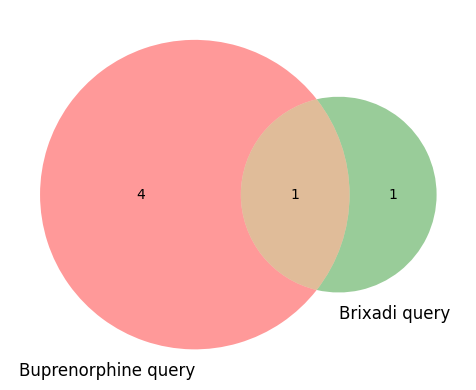

,Buprenorphine query,Brixadi query,set_difference
Buprenorphine -> biolink:related_to -> OPRM1,1.0,0.0,-1.0
Buprenorphine -> biolink:directly_physically_interacts_with -> OPRM1,1.0,0.0,-1.0
Buprenorphine -> biolink:affects -> OPRM1,5.0,0.0,-5.0
Buprenorphine -> biolink:binds -> OPRM1,1.0,0.0,-1.0
OPRM1 -> biolink:genetically_associated_with -> Asterixis,1.0,1.0,0.0
Buprenorphine(+) -> biolink:binds -> OPRM1,0.0,1.0,1.0


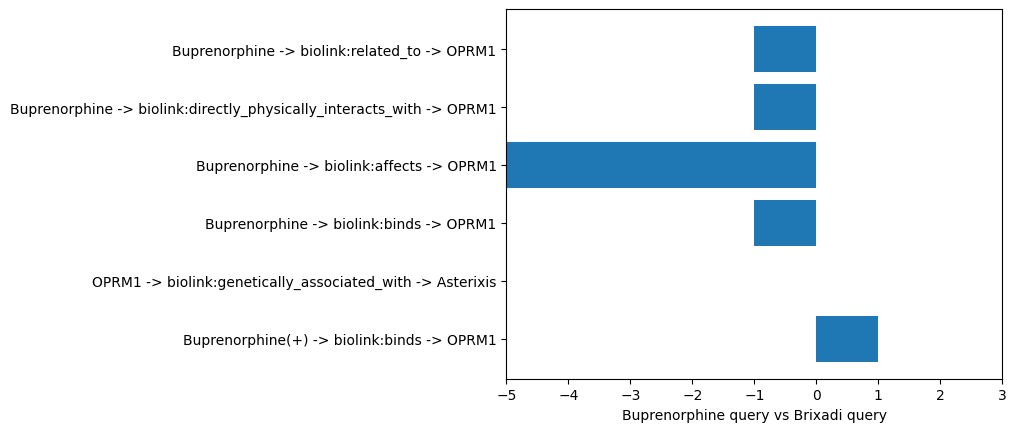

In [16]:
# Demo
output_file_name = os.path.join(write_dir,"compare_brixadi_buprenorphine.txt")
compare_results(dict_trapi_1,dict_trapi_2, output_file_name, "Buprenorphine query", "Brixadi query")